## Multivariate Time Series Analysis


In [1]:
from IPython.display import display, Markdown
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
plt.style.use('ggplot')

In [2]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

### Import Data



In [3]:
dic_country = \
{'AUS': 'Australia',
 'BRA': 'Brazil',
 'CAN': 'India',
 'CHN': 'China',
 'GBR': 'United Kingdom',
 'IND': 'India',
 'JPN': 'Japan',
 'SGP': 'Singapore',
 'USA': 'United States'}
pd.DataFrame(dic_country,index=[0]).T.reset_index().rename(columns = {'index': 'country_code', 0: 'country_name'})

,country_code,country_name
0,AUS,Australia
1,BRA,Brazil
2,CAN,India
3,CHN,China
4,GBR,United Kingdom
5,IND,India
6,JPN,Japan
7,SGP,Singapore
8,USA,United States


In [4]:
Data_dic_m = pd.ExcelFile('Manufacturing_filled.xlsx')
Data_dic_s = pd.ExcelFile('Service_filled.xlsx')

In [5]:
def get_sheet_by_methods(data, method_num, verbose = 0):
  sheet_names = data.sheet_names
  sheet_imputation_map = pd.DataFrame([[s, s[:3].strip(),s[3:]] for s in sheet_names], columns = ['sheet_name', 'country_code', 'imputation method'])
  methods = sheet_imputation_map['imputation method'].unique()
  if verbose:
    print('methods tried:',methods, len(methods))
  return list(sheet_imputation_map.loc[sheet_imputation_map['imputation method'] == methods[method_num]]['sheet_name'].values)

In [6]:
m_dfs = {}
for i in range(len(Data_dic_m.sheet_names) // 10):
  for sheet in get_sheet_by_methods(Data_dic_m, i):
    df = pd.read_excel(Data_dic_m, sheet_name=sheet)
    df['Year'] = [i.year for i in pd.to_datetime(df.Year, format='%Y')]
    df = df.set_index('Year')
    m_dfs[(sheet[:3], sheet[3:].strip())] = df

In [7]:
s_dfs = {}
for i in range(len(Data_dic_s.sheet_names) // 10):
  for sheet in get_sheet_by_methods(Data_dic_s, i):
    df = pd.read_excel(Data_dic_s, sheet_name=sheet)
    df['Year'] = [i.year for i in pd.to_datetime(df.Year, format='%Y')]
    df = df.set_index('Year')
    s_dfs[(sheet[:3], sheet[3:].strip())] = df

In [8]:
# way to retrieve method and country
method = ['Mean','Median','LOCF','NOCB','Rolling statistics']
country = list(dic_country.keys())

m_dfs[(country[0],method[0])] # stands for AUS mean data

,Employment_in_industry_male,Research_development_expenditure,Researchers in R&D,Population_labor_rate,Population_density,Foreign_direct_investment,Air_freight_million_ton_km,Container_port_traffic_TEU,Industry_value_added_current_USD,GDP_per_capita_current_USD,Final_consumption,New_business_density,Employment_in_industry_%_of_total_employment,Manufacturing_value added_%_of_GDP
Year,,,,,,,,,,,,,,
1990,30.583793,1.949895,3899.104492,66.851833,2.221353,2.716689,1222.300049,6.401304e+06,8.961370e+10,18243.471418,2.255137e+11,12.667971,21.196207,13.793444
1991,31.709999,1.949895,3899.104492,66.860327,2.249847,0.801486,1222.599976,6.401304e+06,9.012950e+10,18855.761996,2.458261e+11,12.667971,23.510000,12.569810
1992,31.709999,1.949895,3899.104492,66.781131,2.277313,1.518343,1361.500000,6.401304e+06,8.745366e+10,18604.188270,2.539214e+11,12.667971,23.290001,12.580159
1993,31.670000,1.949895,3899.104492,66.662599,2.299702,1.702015,1525.800049,6.401304e+06,8.372119e+10,17667.187100,2.409823e+11,12.667971,23.299999,12.873184
1994,31.719999,1.949895,3899.104492,66.582205,2.324174,1.381160,1645.500000,6.401304e+06,8.644760e+10,18079.380179,2.456195e+11,12.667971,23.170000,13.205020
1995,31.219999,1.949895,3899.104492,66.572593,2.352420,3.606498,1737.500000,6.401304e+06,9.723938e+10,20358.333356,2.794402e+11,12.667971,22.629999,13.123677
1996,30.610001,1.663230,3355.864990,66.555719,2.383531,1.137889,1833.699951,6.401304e+06,1.041882e+11,21904.294118,3.034181e+11,12.667971,22.129999,12.742416
1997,30.320000,1.949895,3899.104492,66.598197,2.410346,1.857942,1953.800049,6.401304e+06,1.097684e+11,23509.423468,3.258452e+11,12.667971,21.850000,12.303665
1998,30.129999,1.514530,3382.171875,66.676387,2.435599,1.902235,1904.400024,6.401304e+06,1.013654e+11,21345.970987,3.004165e+11,12.667971,21.510000,12.470748


### Time Series Visualization

In [9]:
# can change the argument to plot different country and type
def plot_time_series(df, var_num):
  fig, axes = plt.subplots(var_num//4 + 1,4, dpi=120, figsize=(10,6))
  for i, ax in enumerate(axes.flatten()):
      if (i >= var_num - 1): break
      data = df[df.columns[i]]
      ax.plot(data, color = "lightblue",ms = 1)
      # Decorations
      ax.set_title(df.columns[i+1],fontsize=5)
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=4)

  plt.tight_layout()
  plt.show()

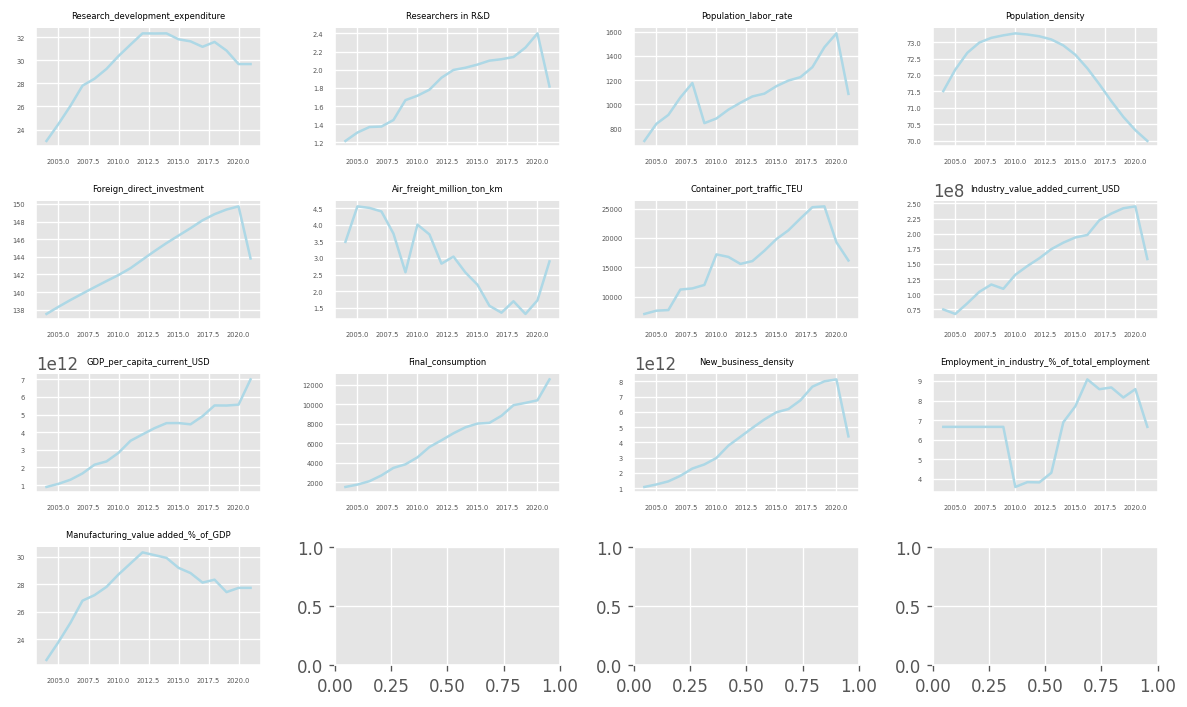

In [ ]:
plot_time_series(m_dfs[('CHN','Mean')],len(m_dfs[('CHN','Mean')].columns))

In [36]:
from statsmodels.tsa.stattools import grangercausalitytests

df = m_dfs[('CHN','Mean')]
corr = grangercausalitytests(df[['Air_freight_million_ton_km','Manufacturing_value added_%_of_GDP']], maxlag = 2)
# df['Air_freight_million_ton_km','Manufacturing_value added_%_of_GDP']


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8487  , p=0.3725  , df_denom=14, df_num=1
ssr based chi2 test:   chi2=1.0306  , p=0.3100  , df=1
likelihood ratio test: chi2=1.0006  , p=0.3172  , df=1
parameter F test:         F=0.8487  , p=0.3725  , df_denom=14, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0903  , p=0.9143  , df_denom=11, df_num=2
ssr based chi2 test:   chi2=0.2626  , p=0.8769  , df=2
likelihood ratio test: chi2=0.2605  , p=0.8779  , df=2
parameter F test:         F=0.0903  , p=0.9143  , df_denom=11, df_num=2


### Granger-Causality Test

In [93]:
from statsmodels.tsa.stattools import grangercausalitytests
def gc_matrix(data, con,m,target, test = 'ssr_chi2test',maxlag =1, verbose = False):
  df = data[(con,m)]
  metrics = pd.DataFrame(np.zeros((1,len(df.columns))),columns = df.columns, index = [target])
  for col in df:
    # print(f"{col}")
    try:
      test_result = grangercausalitytests(df[[col,target]], maxlag = maxlag, verbose = False)
    except Exception as e:
      metrics.loc[target, col] = -1
      if target == 'Manufacturing_value added_%_of_GDP':
        print(f"Manufature {con} {m} {col} contains constant value, cannot perfrom granger-causality test.")
      else:
        print(f"Service {con} {m} {col} contains constant value, cannot perfrom granger-causality test.")
      continue
    p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
    # if verbose: print(f'Y = {target}, X = {col}, P Values = {p_values}')
    min_p_value = np.min(p_values)
    metrics.loc[target, col] = min_p_value
  return metrics

gc_m = {}
gc_s = {}

for con in country:
  for m in method:
    # print(f'=======Manufacture=======')
    res = gc_matrix(m_dfs, con, m, 'Manufacturing_value added_%_of_GDP',verbose = True)
    gc_m[(con,m)] = res

    # print(f'=======Service=======')
    res = gc_matrix(s_dfs, con, m, 'Services_value_added_%_of_GDP',verbose = True)
    gc_s[(con,m)] = res
  print("\n")

Service AUS Mean Unnamed: 9 contains constant value, cannot perfrom granger-causality test.
Service AUS Median Unnamed: 9 contains constant value, cannot perfrom granger-causality test.
Service AUS LOCF Unnamed: 9 contains constant value, cannot perfrom granger-causality test.
Service AUS Rolling statistics Unnamed: 9 contains constant value, cannot perfrom granger-causality test.




Service CAN Mean Access_electricity contains constant value, cannot perfrom granger-causality test.
Service CAN Median Access_electricity contains constant value, cannot perfrom granger-causality test.
Service CAN LOCF Access_electricity contains constant value, cannot perfrom granger-causality test.
Manufature CAN NOCB New_business_density contains constant value, cannot perfrom granger-causality test.
Service CAN NOCB Access_electricity contains constant value, cannot perfrom granger-causality test.
Service CAN NOCB New_business_density contains constant value, cannot perfrom granger-causality test.
Ser

In [99]:
def drop_non_cause(data,matrix, con, m,pvalue = 0.05):
  df = data[(con,m)]
  gc = matrix[(con,m)]
  for col in df.columns:
    if gc[col][0] == 1.0:
      continue
    elif gc[col][0] < 0:
      df = df.drop([col], axis = 1)
    elif gc[col][0] > pvalue:
      df = df.drop([col], axis = 1)
  return df

In [102]:
for con in country:
  for m in method:
    m_dfs[(con,m)] = drop_non_cause(m_dfs, gc_m, con, m)
    s_dfs[(con,m)] = drop_non_cause(s_dfs, gc_s, con, m)

### Correlation checking

In [106]:
from scipy.stats import pearsonr

In [107]:
for con in country:
  for m in method:
    df = m_dfs[(con,m)]
    print(f"=======manufacture {con} {m}=======")
    for col in df:
      corr, _ = pearsonr(df[col], df['Manufacturing_value added_%_of_GDP'])
      print(f'{col} and target: {corr}')
    print("\n")

=======manufacture AUS Mean=======
Population_labor_rate and target: 0.48029414231021084
Population_density and target: -0.9526246812791133
Foreign_direct_investment and target: -0.3327961727521197
Employment_in_industry_%_of_total_employment and target: 0.7757451689034309
Manufacturing_value added_%_of_GDP and target: 1.0


=======manufacture AUS Median=======
Population_labor_rate and target: 0.48029414231021084
Population_density and target: -0.9448691620635943
Foreign_direct_investment and target: -0.33924715101647007
Employment_in_industry_%_of_total_employment and target: 0.7777262087399569
Manufacturing_value added_%_of_GDP and target: 1.0


=======manufacture AUS LOCF=======
Population_labor_rate and target: 0.48029414231021084
Population_density and target: -0.9852716774111966
Foreign_direct_investment and target: -0.29444910312418027
Manufacturing_value added_%_of_GDP and target: 1.0


=======manufacture AUS NOCB=======
Population_labor_rate and target: 0.48029414231021084
Ma

### Stationarity

In [108]:
def adfuller_simple(series, name,signif=0.05):
  r = adfuller(series, autolag='AIC')
  output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
  p_value = output['pvalue'] 
  if p_value <= signif: 
    print(f"{name}: TRUE")
    return True
  else:
    print(f"{name}: FALSE")
    return False

In [109]:
def adf_testing(df,con,is_manu):
  if is_manu:
    print(f"=======Manufacture {con}=======")
  else:
    print(f"=======Service {con}=======")
  for name, column in df.iteritems():
    adfuller_simple(column, name=column.name)

In [110]:
for m in method:
  print(f"=======Imputation using {m}=======")
  for con in country:
    adf_testing(m_dfs[(con,m)],con,True)
    print("\n")
    adf_testing(s_dfs[(con,m)],con,False)
    print("\n")

=======Imputation using Mean=======
=======Manufacture AUS=======
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: TRUE
Employment_in_industry_%_of_total_employment: FALSE
Manufacturing_value added_%_of_GDP: FALSE


=======Service AUS=======
Employment_in_services_male: FALSE
Net_trade_in_goods_services: FALSE
Foreign_direct_investment: TRUE
School_enrollment_tertiary: FALSE
Population_labor_rate: FALSE
Access_electricity: FALSE
Services_value_added_%_of_GDP: TRUE


=======Manufacture BRA=======
Population_labor_rate: TRUE
Foreign_direct_investment: FALSE
Manufacturing_value added_%_of_GDP: FALSE


=======Service BRA=======
Population_labor_rate: TRUE
Poverty_headcount_ratio: FALSE
Services_value_added_%_of_GDP: FALSE


=======Manufacture CAN=======
Employment_in_industry_male: FALSE
Research_development_expenditure: FALSE
Population_labor_rate: FALSE
Air_freight_million_ton_km: FALSE
Container_port_traffic_TEU: FALSE
Employment_in_industry_%_of_total_e

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Population_labor_rate: FALSE
New_business_density: FALSE
Manufacturing_value added_%_of_GDP: FALSE


=======Service SGP=======
Foreign_direct_investment: TRUE
Population_labor_rate: FALSE
Services_value_added_%_of_GDP: FALSE


=======Manufacture USA=======
Researchers in R&D: FALSE
Population_labor_rate: FALSE
Air_freight_million_ton_km: FALSE
Container_port_traffic_TEU: FALSE
Manufacturing_value added_%_of_GDP: FALSE


=======Service USA=======
Secure_Internet_servers: FALSE
School_enrollment_tertiary: FALSE
Population_labor_rate: FALSE
Services_value_added_%_of_GDP: FALSE


=======Imputation using Median=======
=======Manufacture AUS=======
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: TRUE
Employment_in_industry_%_of_total_employment: FALSE
Manufacturing_value added_%_of_GDP: FALSE


=======Service AUS=======
Employment_in_services_male: FALSE
Net_trade_in_goods_services: FALSE
Foreign_direct_investment: TRUE
School_enrollment_tertiary: FALSE
Popu

#### First Order Difference

In [111]:
# perform first order difference
diff_manu = {}
diff_ser = {}
for m in method:
  for con in country:
    diff_manu[(con,m)] = m_dfs[(con,m)].diff().dropna()
    diff_ser[(con,m)] = s_dfs[(con,m)].diff().dropna()

In [112]:
for m in method:
  print(f"=======Imputation using {m}=======")
  for con in country:
    adf_testing(diff_manu[(con,m)],con,True)
    print("\n")
    adf_testing(diff_ser[(con,m)],con,False)
    print("\n")

=======Imputation using Mean=======
=======Manufacture AUS=======
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: TRUE
Employment_in_industry_%_of_total_employment: TRUE
Manufacturing_value added_%_of_GDP: TRUE


=======Service AUS=======
Employment_in_services_male: FALSE
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
School_enrollment_tertiary: FALSE
Population_labor_rate: FALSE
Access_electricity: TRUE
Services_value_added_%_of_GDP: TRUE


=======Manufacture BRA=======
Population_labor_rate: FALSE
Foreign_direct_investment: FALSE
Manufacturing_value added_%_of_GDP: TRUE


=======Service BRA=======
Population_labor_rate: FALSE
Poverty_headcount_ratio: TRUE
Services_value_added_%_of_GDP: TRUE


=======Manufacture CAN=======
Employment_in_industry_male: TRUE
Research_development_expenditure: TRUE
Population_labor_rate: FALSE
Air_freight_million_ton_km: FALSE
Container_port_traffic_TEU: TRUE
Employment_in_industry_%_of_total_employmen

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Manufacturing_value added_%_of_GDP: TRUE


=======Service SGP=======
Foreign_direct_investment: TRUE
Population_labor_rate: FALSE
Services_value_added_%_of_GDP: TRUE


=======Manufacture USA=======
Researchers in R&D: TRUE
Population_labor_rate: TRUE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: TRUE
Manufacturing_value added_%_of_GDP: TRUE


=======Service USA=======
Secure_Internet_servers: FALSE
School_enrollment_tertiary: TRUE
Population_labor_rate: TRUE
Services_value_added_%_of_GDP: TRUE


=======Imputation using Median=======
=======Manufacture AUS=======
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: TRUE
Employment_in_industry_%_of_total_employment: TRUE
Manufacturing_value added_%_of_GDP: TRUE


=======Service AUS=======
Employment_in_services_male: FALSE
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
School_enrollment_tertiary: TRUE
Population_labor_rate: FALSE
Access_electricity: TRUE
Services_value_added_

#### Second Order Difference

In [113]:
# perform second order difference
diff2_manu = {}
diff2_ser = {}
for m in method:
  for con in country:
    diff2_manu[(con,m)] = diff_manu[(con,m)].diff().dropna()
    diff2_ser[(con,m)] = diff_ser[(con,m)].diff().dropna()

In [114]:
for m in method:
  print(f"=======Imputation using {m}=======")
  for con in country:
    adf_testing(diff2_manu[(con,m)],con,True)
    print("\n")
    adf_testing(diff2_ser[(con,m)],con,False)
    print("\n")

=======Imputation using Mean=======
=======Manufacture AUS=======
Population_labor_rate: TRUE
Population_density: FALSE
Foreign_direct_investment: TRUE
Employment_in_industry_%_of_total_employment: TRUE
Manufacturing_value added_%_of_GDP: TRUE


=======Service AUS=======
Employment_in_services_male: TRUE
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
School_enrollment_tertiary: FALSE
Population_labor_rate: TRUE
Access_electricity: FALSE
Services_value_added_%_of_GDP: TRUE


=======Manufacture BRA=======
Population_labor_rate: TRUE
Foreign_direct_investment: TRUE
Manufacturing_value added_%_of_GDP: TRUE


=======Service BRA=======
Population_labor_rate: TRUE
Poverty_headcount_ratio: TRUE
Services_value_added_%_of_GDP: TRUE


=======Manufacture CAN=======
Employment_in_industry_male: TRUE
Research_development_expenditure: FALSE
Population_labor_rate: TRUE
Air_freight_million_ton_km: FALSE
Container_port_traffic_TEU: TRUE
Employment_in_industry_%_of_total_employment: TR

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Manufacturing_value added_%_of_GDP: TRUE


=======Service SGP=======
Foreign_direct_investment: TRUE
Population_labor_rate: TRUE
Services_value_added_%_of_GDP: TRUE


=======Manufacture USA=======
Researchers in R&D: FALSE
Population_labor_rate: FALSE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: FALSE
Manufacturing_value added_%_of_GDP: FALSE


=======Service USA=======
Secure_Internet_servers: FALSE
School_enrollment_tertiary: FALSE
Population_labor_rate: FALSE
Services_value_added_%_of_GDP: TRUE


=======Imputation using Median=======
=======Manufacture AUS=======
Population_labor_rate: TRUE
Population_density: FALSE
Foreign_direct_investment: TRUE
Employment_in_industry_%_of_total_employment: TRUE
Manufacturing_value added_%_of_GDP: TRUE


=======Service AUS=======
Employment_in_services_male: TRUE
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
School_enrollment_tertiary: FALSE
Population_labor_rate: TRUE
Access_electricity: TRUE
Services_value_add

#### Linear Detrend (TO-DO)

#### Drop Non-stationary variable for model fitting

In [115]:
def drop_non_stat(df):
  adf = df
  for name, column in adf.iteritems():
      if not adfuller_simple(column, name=column.name):
        adf = adf.drop([column.name], axis = 1)
      else:
        continue
  return adf

In [116]:
df_manu = {}
df_ser = {}
for m in method:
  for con in country:
    print(f"==={con} {m} manufacture===")
    df_manu[(con,m)] = drop_non_stat(diff2_manu[(con,m)])
    print(f"==={con} {m} service===")
    df_ser[(con,m)] = drop_non_stat(diff2_ser[(con,m)])

===AUS Mean manufacture===
Population_labor_rate: TRUE
Population_density: FALSE
Foreign_direct_investment: TRUE
Employment_in_industry_%_of_total_employment: TRUE
Manufacturing_value added_%_of_GDP: TRUE
===AUS Mean service===
Employment_in_services_male: TRUE
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
School_enrollment_tertiary: FALSE
Population_labor_rate: TRUE
Access_electricity: FALSE
Services_value_added_%_of_GDP: TRUE
===BRA Mean manufacture===
Population_labor_rate: TRUE
Foreign_direct_investment: TRUE
Manufacturing_value added_%_of_GDP: TRUE
===BRA Mean service===
Population_labor_rate: TRUE
Poverty_headcount_ratio: TRUE
Services_value_added_%_of_GDP: TRUE
===CAN Mean manufacture===
Employment_in_industry_male: TRUE
Research_development_expenditure: FALSE
Population_labor_rate: TRUE
Air_freight_million_ton_km: FALSE
Container_port_traffic_TEU: TRUE
Employment_in_industry_%_of_total_employment: TRUE
Manufacturing_value added_%_of_GDP: TRUE
===CAN Mean ser

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Researchers in R&D: FALSE
Population_labor_rate: FALSE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: FALSE
Manufacturing_value added_%_of_GDP: FALSE
===USA Mean service===
Secure_Internet_servers: FALSE
School_enrollment_tertiary: FALSE
Population_labor_rate: FALSE
Services_value_added_%_of_GDP: TRUE
===AUS Median manufacture===
Population_labor_rate: TRUE
Population_density: FALSE
Foreign_direct_investment: TRUE
Employment_in_industry_%_of_total_employment: TRUE
Manufacturing_value added_%_of_GDP: TRUE
===AUS Median service===
Employment_in_services_male: TRUE
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
School_enrollment_tertiary: FALSE
Population_labor_rate: TRUE
Access_electricity: TRUE
Services_value_added_%_of_GDP: TRUE
===BRA Median manufacture===
Population_labor_rate: TRUE
Foreign_direct_investment: TRUE
Manufacturing_value added_%_of_GDP: TRUE
===BRA Median service===
Population_labor_rate: TRUE
Poverty_headcount_ratio: TRUE
Services_value_

### Model Fitting

#### Train-test split

In [124]:
for m in method:
  for con in country:
    print(f"Manufacture {con} {m}: {len(df_manu[(con,m)].columns)}")

    print(f"Service {con} {m}: {len(df_ser[(con,m)].columns)}")


Manufacture AUS Mean: 4
Service AUS Mean: 5
Manufacture BRA Mean: 3
Service BRA Mean: 3
Manufacture CAN Mean: 5
Service CAN Mean: 3
Manufacture CHN Mean: 3
Service CHN Mean: 3
Manufacture GBR Mean: 6
Service GBR Mean: 2
Manufacture IND Mean: 1
Service IND Mean: 2
Manufacture JPN Mean: 5
Service JPN Mean: 3
Manufacture SGP Mean: 3
Service SGP Mean: 3
Manufacture USA Mean: 1
Service USA Mean: 1
Manufacture AUS Median: 4
Service AUS Median: 6
Manufacture BRA Median: 3
Service BRA Median: 3
Manufacture CAN Median: 5
Service CAN Median: 4
Manufacture CHN Median: 2
Service CHN Median: 2
Manufacture GBR Median: 6
Service GBR Median: 3
Manufacture IND Median: 4
Service IND Median: 3
Manufacture JPN Median: 5
Service JPN Median: 2
Manufacture SGP Median: 3
Service SGP Median: 3
Manufacture USA Median: 1
Service USA Median: 2
Manufacture AUS LOCF: 4
Service AUS LOCF: 4
Manufacture BRA LOCF: 3
Service BRA LOCF: 2
Manufacture CAN LOCF: 4
Service CAN LOCF: 1
Manufacture CHN LOCF: 3
Service CHN LOCF

In [117]:
def split_train_test(df, valid_num = 5):
    train = df[:-valid_num]
    valid = df[-valid_num:]
    return train, valid

train_manu = {}
valid_manu = {}
train_ser = {}
valid_ser = {}
for m in method:
  for con in country:
    train_manu[(con,m)], valid_manu[(con,m)]= split_train_test(df_manu[(con,m)])
    train_ser[(con,m)], valid_ser[(con,m)]= split_train_test(df_ser[(con,m)])

#### VAR Model Fitting

In [118]:
from statsmodels.tsa.vector_ar.var_model import VAR

In [134]:
# select the order of model
model_manu = {}
model_ser = {}
for m in method:
  for con in country:
    if len(train_manu[(con,m)].columns) > 1:
      model = VAR(endog=train_manu[(con,m)])
      res = model.fit()
      model_manu[(con,m)] = res
    if len(train_ser[(con,m)].columns) > 1:
      model = VAR(endog=train_ser[(con,m)])
      res = model.fit()
      model_ser[(con,m)] = res

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was pro

#### Diagnostic Check

Using Ljung-Box test to perform diagnostic check

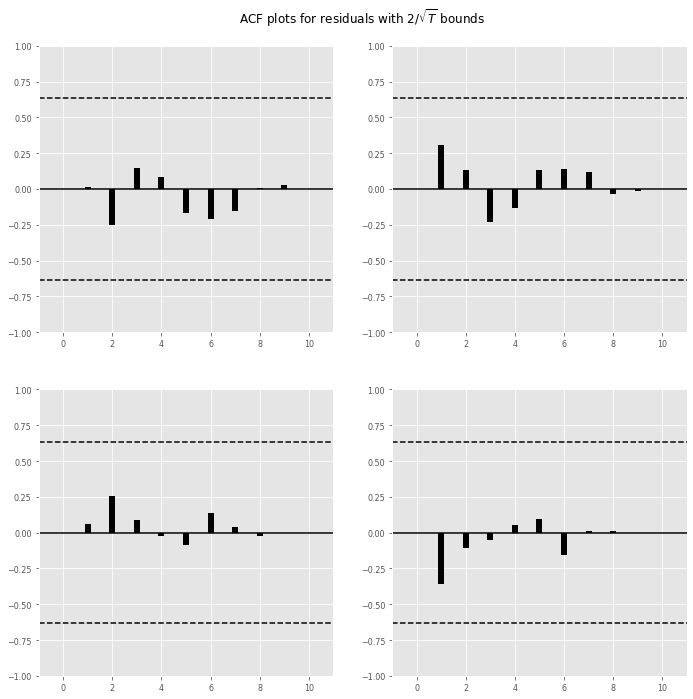

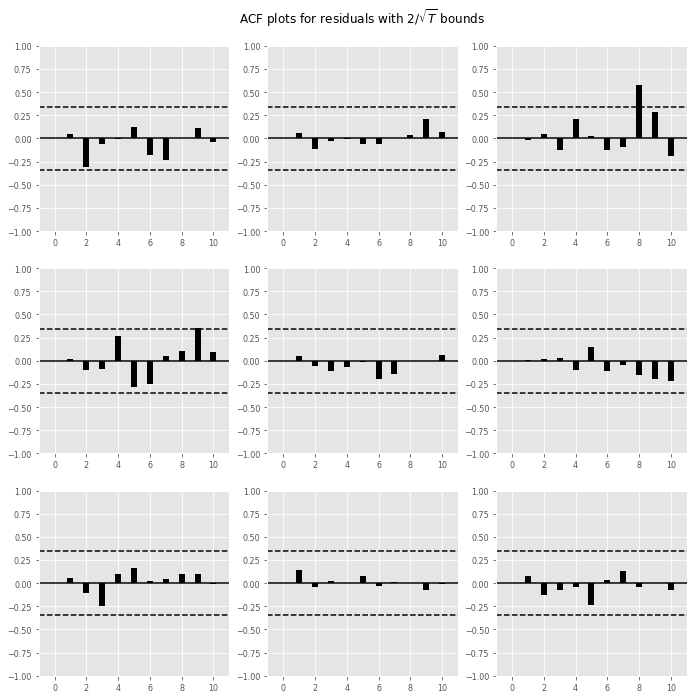

In [127]:
# for m in method:
#   for con in country:
#     model_manu[(con,m)].plot_acorr(nlags=10, resid=True, linewidth=6)
#     model_ser[(con,m)].plot_acorr(nlags=10, resid=True, linewidth=6)
#     plt.show()
# can be used as reference for all residual checking
model_manu[('CHN','Rolling statistics')].plot_acorr(nlags=10, resid=True, linewidth=6)
model_ser[('CHN','Rolling statistics')].plot_acorr(nlags=10, resid=True, linewidth=6)
plt.show()

#### Forecasting

In [135]:
forecast_manu = {}
forecast_ser = {}
def forecast_var(model, train,valid,con, manu):
  forecast = model.forecast(train.values, steps = len(valid))
  df_forecast = pd.DataFrame(data = forecast,columns = train.columns,index = valid.index)
  manu[(con,m)] = df_forecast
for m in method:
  for con in country:
    if len(train_manu[(con,m)].columns) > 1:
      forecast_var(model_manu[(con,m)],train_manu[(con,m)], valid_manu[(con,m)],con, forecast_manu)
    if len(train_ser[(con,m)].columns) > 1:
      forecast_var(model_ser[(con,m)],train_ser[(con,m)], valid_ser[(con,m)],con, forecast_ser)

In [136]:
def invert_second_diff(df,test_obs = 5):
  df_ori = df
  for col_name in df_ori:
    df_ori[col_name+"_1d"] = df[col_name].iloc[-test_obs-1] - df[col_name].iloc[-test_obs-2] +df[col_name].cumsum()
    df_ori[col_name+"_forecasted"] = df[col_name].iloc[-test_obs-1] + df[col_name+"_1d"].cumsum()
    df[col_name] = df_ori[[col_name+"_forecasted"]]
  return df

### Evaluation

In [130]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error

In [141]:
m_metrics = {}
s_metrics = {}
for m in method:
  for con in country:
    if len(train_manu[(con,m)].columns) > 1 and 'Manufacturing_value added_%_of_GDP' in valid_manu[(con,m)].columns:
      y = valid_manu[(con,m)]['Manufacturing_value added_%_of_GDP']
      yhat = forecast_manu[(con,m)]['Manufacturing_value added_%_of_GDP']
      mae = mean_absolute_error(y, yhat)
      mape = mean_absolute_percentage_error(y, yhat)
      rmse = sqrt(mean_squared_error(y, yhat))
      eval =  [mae,rmse,mape]
    #print(mae, mse, rmse, con)
      m_metrics[(con,m)] = eval
    elif len(train_manu[(con,m)].columns) == 1:
      print(f'Only contains target variable for service {con} {m}.')
      s_metrics[(con,m)] = [np.nan,np.nan,np.nan]
    else:
      print(f'Target variable for manufaturce {con} {m} is non-stationary.')
      m_metrics[(con,m)] = [np.nan,np.nan,np.nan]

    if  len(train_ser[(con,m)].columns) > 1 and 'Services_value_added_%_of_GDP' in valid_ser[(con,m)].columns:
      y = valid_ser[(con,m)]['Services_value_added_%_of_GDP']
      yhat = forecast_ser[(con,m)]['Services_value_added_%_of_GDP']
      mae = mean_absolute_error(y, yhat)
      mape = mean_absolute_percentage_error(y, yhat)
      rmse = sqrt(mean_squared_error(y, yhat))
      eval = [mae,rmse,mape]
      #print(mae, mse, rmse, con)
      s_metrics[(con,m)] = eval
    elif len(train_ser[(con,m)].columns) == 1:
      print(f'Only contains target variable for service {con} {m}.')
      s_metrics[(con,m)] = [np.nan,np.nan,np.nan]
    else:
      print(f'Target variable for service {con} {m} is non-stationary.')
      s_metrics[(con,m)] = [np.nan,np.nan,np.nan]

Target variable for service CAN Mean is non-stationary.
Only contains target variable for service IND Mean.
Target variable for service IND Mean is non-stationary.
Only contains target variable for service USA Mean.
Only contains target variable for service USA Mean.
Target variable for service CAN Median is non-stationary.
Target variable for service IND Median is non-stationary.
Only contains target variable for service USA Median.
Only contains target variable for service CAN LOCF.
Only contains target variable for service IND LOCF.
Target variable for manufaturce USA LOCF is non-stationary.
Only contains target variable for service CAN NOCB.
Only contains target variable for service CHN NOCB.
Only contains target variable for service GBR NOCB.
Only contains target variable for service IND NOCB.
Target variable for service IND NOCB is non-stationary.
Target variable for manufaturce USA NOCB is non-stationary.
Only contains target variable for service USA NOCB.
Target variable for se

In [142]:
m_eval = pd.DataFrame(m_metrics).transpose()
m_eval.columns = ['MAE', 'RMSE','MAPE']

m_eval

,,MAE,RMSE,MAPE
AUS,Mean,0.138164,0.151619,0.869970
BRA,Mean,0.436123,0.515535,10.665171
CAN,Mean,0.439865,0.501961,1.012039
CHN,Mean,0.967912,1.115118,1.128988
GBR,Mean,0.114180,0.135673,0.976106
JPN,Mean,0.453944,0.561849,1.484007
SGP,Mean,1.659844,1.939286,0.956096
AUS,Median,0.138230,0.151729,0.869802
BRA,Median,0.436123,0.515535,10.665171
CAN,Median,0.440167,0.502105,1.013424


In [143]:
s_eval = pd.DataFrame(s_metrics).transpose()
s_eval.columns = ['MAE','RMSE','MAPE']
s_eval

,,MAE,RMSE,MAPE
AUS,Mean,0.912740,0.956682,1.482904
BRA,Mean,1.412399,1.669583,1.134239
CAN,Mean,NaN,NaN,NaN
CHN,Mean,0.864284,0.932615,1.156871
GBR,Mean,1.112938,1.579897,20.276211
IND,Mean,NaN,NaN,NaN
JPN,Mean,0.357605,0.493297,1.178145
SGP,Mean,1.529578,1.864179,1.000653
USA,Mean,NaN,NaN,NaN
AUS,Median,0.969125,1.041925,1.341826


### Special case for manufacture USA and Service IND

By difference result, we can see that manufacture USA and Service IND can be stationary with first order difference.

In [144]:
# drop non-stationary
usa_manu={}
can_ser= {}
for m in method:
  usa_manu[m] = drop_non_stat(diff_manu[('USA',m)])
  can_ser[m] = drop_non_stat(diff_ser[('IND',m)])

Researchers in R&D: TRUE
Population_labor_rate: TRUE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: TRUE
Manufacturing_value added_%_of_GDP: TRUE
Foreign_direct_investment: TRUE
Population_labor_rate: TRUE
Poverty_headcount_ratio: TRUE
Services_value_added_%_of_GDP: TRUE
Researchers in R&D: TRUE
Population_labor_rate: TRUE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: TRUE
Manufacturing_value added_%_of_GDP: TRUE
Foreign_direct_investment: TRUE
Population_labor_rate: TRUE
Individuals_using_the_Internet_%_of_population: FALSE
Poverty_headcount_ratio: TRUE
Services_value_added_%_of_GDP: TRUE
Employment_in_industry_male: FALSE
Population_labor_rate: TRUE
Air_freight_million_ton_km: TRUE
Employment_in_industry_%_of_total_employment: FALSE
Manufacturing_value added_%_of_GDP: TRUE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
School_enrollment_tertiary: FALSE
Population_labor_rate: TRUE
Services_value_added_%_of_GDP: TRUE
Population_labor_r

In [145]:
train_usa = {}
valid_usa = {}
train_can = {}
valid_can = {}
for m in method:
  if len(usa_manu[m].columns) > 1:
    train_usa[m], valid_usa[m]= split_train_test(usa_manu[m])

  if len(can_ser[m].columns) > 1:
    train_can[m], valid_can[m]= split_train_test(can_ser[m])

In [147]:
# select the order of model
model_usa = {}
model_can = {}
for m in method:
  if len(usa_manu[m].columns) > 1:
    model = VAR(endog=train_usa[m])
    res = model.fit()
    model_usa[m] = res
  if len(can_ser[m].columns) > 1:
    model = VAR(endog=train_can[m])
    res = model.fit()
    model_can[m] = res

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was pro

In [148]:
forecast_usa = {}
forecast_can = {}
for m in method:
  if len(usa_manu[m].columns) > 1:
    forecast_var(model_usa[m],train_usa[m], valid_usa[m],'USA', forecast_usa)
  if len(can_ser[m].columns) > 1:
    forecast_var(model_can[m],train_can[m], valid_can[m],'IND', forecast_can)

In [149]:
valid_can['Mean']

,Foreign_direct_investment,Population_labor_rate,Poverty_headcount_ratio,Services_value_added_%_of_GDP
Year,,,,
2017,-0.430047,0.263925,-4.700000,-0.078511
2018,0.050898,0.228555,-2.300000,0.760676
2019,0.229167,0.237069,-1.100000,1.676103
2020,0.625283,0.261689,19.190909,-1.670812
2021,-1.453936,0.179688,0.000000,-0.746430


In [150]:
m_metrics = {}
s_metrics = {}
for m in method:
  if len(usa_manu[m].columns) > 1 and 'Manufacturing_value added_%_of_GDP' in valid_usa[m].columns:
    y = valid_usa[m]['Manufacturing_value added_%_of_GDP']
    yhat = forecast_usa[('USA',m)]['Manufacturing_value added_%_of_GDP']
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = sqrt(mean_squared_error(y, yhat))
    eval = [mae,rmse,mape]
      #print(mae, mse, rmse, con)
    m_metrics[('USA',m)] = eval
  elif len(usa_manu[m].columns) == 1:
    print(f'Only contains target variable for manufaturce USA {m}.')
    m_metrics[('USA',m)] = [np.nan,np.nan,np.nan]
  else:
    print(f'Target variable for manufaturce USA {m} is non-stationary.')
    m_metrics[('USA',m)] = [np.nan,np.nan,np.nan]

  if len(can_ser[m].columns) > 1 and 'Services_value_added_%_of_GDP' in valid_can[m]:
    y = valid_can[m]['Services_value_added_%_of_GDP']
    yhat = forecast_can[('IND',m)]['Services_value_added_%_of_GDP']
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = sqrt(mean_squared_error(y, yhat))
    eval =  [mae,rmse,mape]
        #print(mae, mse, rmse, con)
    s_metrics[('IND',m)] = eval
  elif len(can_ser[m].columns) == 1:
    print(f'Only contains target variable for IND service {m}.')
    s_metrics[('IND',m)] = [np.nan,np.nan,np.nan]
  else:
    print(f'Target variable for service IND {m} is non-stationary.')
    s_metrics[('IND',m)] = [np.nan,np.nan,np.nan]

In [151]:
m_eval = pd.DataFrame(m_metrics).transpose()
m_eval.columns = ['MAE', 'RMSE','MAPE']
m_eval

MAE      RMSE      MAPE
USA Mean                0.168625  0.258264  0.584805
    Median              0.168409  0.258017  0.582744
    LOCF                0.169373  0.256580  0.588613
    NOCB                0.181858  0.272508  0.707849
    Rolling statistics  0.058571  0.065576  0.601001

In [152]:
s_eval = pd.DataFrame(s_metrics).transpose()
s_eval.columns = ['MAE','RMSE','MAPE']
s_eval

MAE      RMSE      MAPE
IND Mean                1.059873  1.234986  1.967913
    Median              1.058993  1.235054  1.961660
    LOCF                1.063455  1.233997  1.993407
    NOCB                1.065522  1.234388  2.010361
    Rolling statistics  0.143334  0.174563  1.484907